# Homework 4- Table of Contents

### [Task 1. Propensity score matching](#1)
- [Plot Functions](#1plot)

- [1.1. A naive analysis](#11)

- [1.2. A closer look at the data](#12)

- [1.3. A propensity score model](#13)

- [1.4. Balancing the dataset via matching](#14)

- [1.5. Balancing the groups further](#15)

- [1.6. A less naive analysis](#14)


### [Task 2. Applied ML](#2)
- [2.1. Load data](#21)

- [2.2. Train data with random forest](#22)

## Task 1. Propensity Score Matching <a class="anchor" id="1"></a>

### Assignment Instructions
In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

### Imports

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
from scipy.stats import norm
import matplotlib.mlab as mlab
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

#### Data

In [3]:
df = pd.read_csv('lalonde.csv', index_col = 0)
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We check that data doesn't have any missing/null values:

In [4]:
df.notnull().values.any()

True

#### Assumptions
The dataset contain several records with zero values for real earnings. Since we are trying to evaluate the efectiveness of the job program in the real earnings, we should also consider those who did not find a job. For this reason, we will keep these values in a first iterarion over the problem.

### Plot Functions<a class="anchor" id="1plot"></a>

We define the following functions to be used during the homework, when plotting and analysing the variables:

In [5]:
def enumerate_df(treated_df, control_df):
    """
    Gives an enumerated data frame list.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :return: enumerated list of data frames
    """
    dataframes = [('Treated', treated_df), ('Control', control_df)]
    return enumerate(dataframes)

def initiate_plot_and_enumerate_df(treated_df, control_df):
    """
    Initiates plot and gives an enumerated data frame list.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :return: axes of the figure initiated, enumerated list of data frames
    """
    fig, axes = plt.subplots(1, 2, figsize = (8, 4), sharex = True, sharey = True)
    return axes, enumerate_df(treated_df, control_df)

def plot_hist(treated_df, control_df, features, title, range_):
    """
    Plots histograms of the treated and control groups for the features given.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :param features: list of strings
    :param title: Plot Title, string
    :param range_: tuple of integers
    """
    axes, dataframes = initiate_plot_and_enumerate_df(treated_df, control_df)
    for index, (group_type, df) in dataframes:
        for feature in features:
            df[feature].plot.hist(ax = axes[index], 
                                  weights = np.zeros_like(df[feature]) + 1. / df[feature].size, 
                                  title = group_type + ' Group: ' + title,
                                  range = range_,
                                  alpha = 0.5,
                                  label = feature,
                                  bins = 20)
        axes[index].legend(loc="upper right")
    
def plot_box(treated_df, control_df, feature, title):
    """
    Plots a box chart for a categorical feature for both groups.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :param feature: string
    :param title: Plot Title, string
    :param print_values: boolean, prints values if True
    """
    axes, dataframes = initiate_plot_and_enumerate_df(treated_df, control_df)
    for index, (group_type, df) in dataframes:
        df[feature].plot.box(
            ax = axes[index], 
            title = group_type + ' Group: ' + title, 
            label = feature)
    
def plot_bar(treated_df, control_df, feature, title, print_values=False):
    """
    Plots a bar chart for a categorical feature for both groups.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :param feature: string
    :param title: Plot Title, string
    :param print_values: boolean, prints values if True
    """
    axes, dataframes = initiate_plot_and_enumerate_df(treated_df, control_df)
    for index, (group_type, df) in dataframes:
        values = (df[feature].value_counts()/df[feature].size).sort_index()
        values.plot.bar(
            ax = axes[index], 
            title = group_type + ' Group: ' + title,
            alpha = 0.5,
            label = feature)
        if print_values:
            print('The distribution in the {} group takes the following values: \n{}'.format(
                group_type, values))

def plot_distribution(treated_df, control_df, feature, feature_name, bins=50):
    """
    Plots distribution of both groups given a feature.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :param feature: string
    :param feature_name: string
    :param bins: int
    """
    # Defining variables for plotting
    colors = 'g b c k m y r'.split(' ')
    max_range = max([max(treated_df[feature]), max(control_df[feature])])
    dataframes = enumerate_df(treated_df, control_df)
    
    # Plotting
    plt.figure(figsize=(14,7))
    for index, (group_type, df) in dataframes:
        plt.subplot(1, 2, index + 1)
        colors = [colors[0], colors[-1]]
        # Plotting histogram
        n, bins, patches = plt.hist(
            df[feature], bins, normed=True, 
            facecolor=colors[0], range=(0,max_range))
        # best fit of data
        (mu, sigma) = norm.fit(df[feature])
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, colors[-1] + '--', linewidth=3)
        # Plot Title
        plt.title('{} Group: {}'.format(group_type, feature_name))

### 1.1. A Naive Analysis<a class="anchor" id="11"></a>

#### Question Instructions

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Answer

At this point, we will start by comparing the distribution of the outcome variable (re78) between the two groups in an naively way, this is, without questioning the bias of such data. 

We start by spliting the treatment group and control group in two different categories:

In [6]:
treated = df[(df.treat == 1)]
control = df[(df.treat == 0)]

Let's check the general numerical values of real earning in the year of 1978 for both groups:

In [7]:
#Real earnings description for people who took the job trainig program
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [8]:
#Real earnings description for people who did not take the job trainig program
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

Let's represent the values above with some plots. Note that for the following representations we consider relative values, since those are more meaningful comparing two groups of different size.

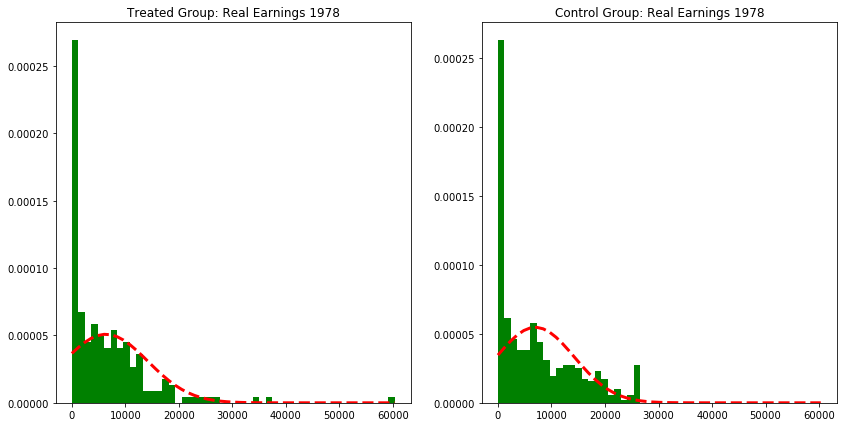

In [9]:
plot_distribution(treated, control, 're78', 'Real Earnings 1978')

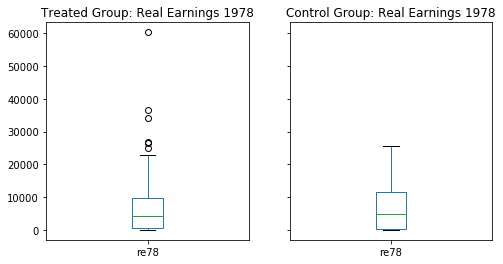

In [10]:
plot_box(treated, control, 're78', 'Real Earnings 1978')

**Observations:**

Considering what we know so far, there are several points that stand out in the descriptions above. 
One can see that the **mean** is higher for the control group, with a relative difference of approximately 9%.

Note that the **quartiles** play an important role in this analysis since their robustness to outliers. We check that only for the first quartile, the trated group has a higher value, since for the following ones the control group present higher earnings. 

From the analysis above, one can (naively) conclude that the treatment was not effective.

### 1.2. A closer look at the data<a class="anchor" id="12"></a>

#### Question Instructions

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Answer

Let's take a closer look at the data before jumping to conclusions:

One can not just take into account the real earning in the year of 1978 to justify the  effectiveness of the "treatment" represented by the job training program. This could be biased. A good analysis should consider the "story" of a person, since it's obvious that people with higher education, or those who already had higher real earning values in the past few years are more likely to earn more, independently if they took the program or not.

For each feature in the dataset, we compare its distribution in the treated group with its distribution in the control group, using plots and numbers.

**Is `age` equally distributed in both groups?**

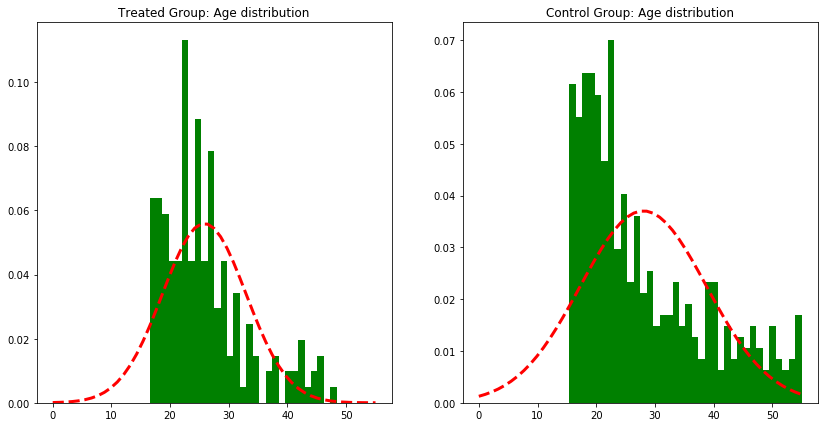

In [11]:
plot_distribution(treated, control, 'age', 'Age distribution')

Eventhough the difference is not impressive, we can verify that the control group has a higher percentage of **older people**, as the curve is more skewed towards the right than for the treated group. This is relevant since higher earnings are usually associated with more years of professional experience.

**Do both groups have a simillar `education`?**

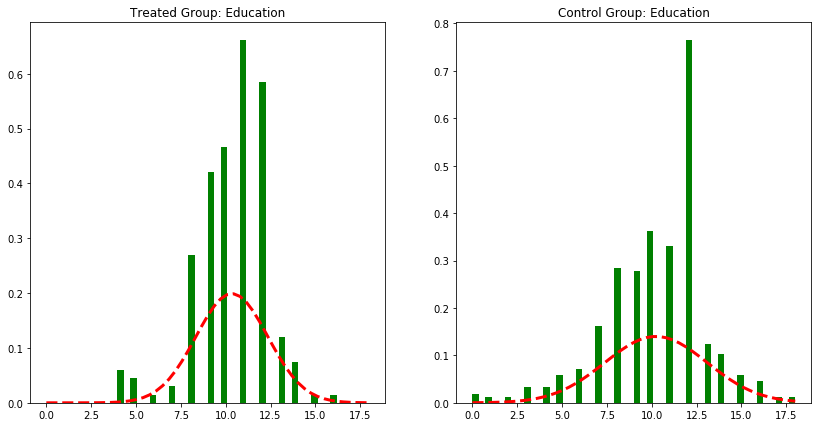

In [12]:
plot_distribution(treated, control, 'educ', 'Education')

Let's compare the mean of education years in both groups:

In [13]:
mean_relativeDifference = (treated.educ.mean() - control.educ.mean()) * 100 / treated.educ.mean()
print("There's a {}% difference when comparing the mean of years of education for both groups".
      format(mean_relativeDifference))

There's a 1.068193387942603% difference when comparing the mean of years of education for both groups


A difference in the distribution of years of education could affect the bias of the results, since more years of study are likely to be correlated with higher real earnings as well. However, the difference is just 1%, which is almost neglible.

**Are the three different `races` equally distributed in both groups?**

The distribution in the Treated group takes the following values: 
0    0.156757
1    0.843243
Name: black, dtype: float64
The distribution in the Control group takes the following values: 
0    0.797203
1    0.202797
Name: black, dtype: float64


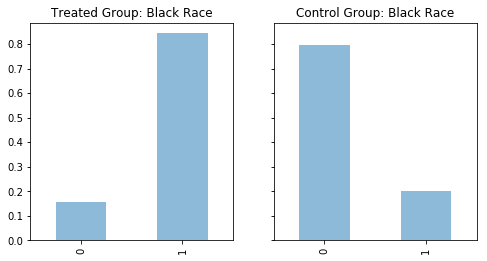

In [14]:
plot_bar(treated, control, 'black', 'Black Race', print_values = True)

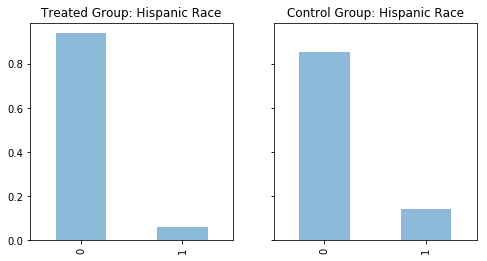

In [15]:
plot_bar(treated, control, 'hispan', 'Hispanic Race')

We can verify that the hispanic race is a minority in both groups. However, the same does not apply to the black race. In fact, more that 80% of people in the trated group belong to black race, in comparison with 20% in the non-treated group.

**How is the `marrital status` distribuded in these two groups?**

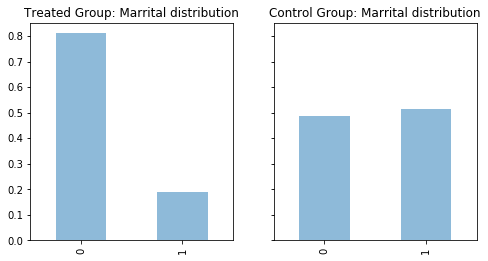

In [16]:
plot_bar(treated, control, 'married', 'Marrital distribution')

The marrital distribution is not exactly the same. However, one should also take into account that this parameter is not so likely to influence the real earnings. Since `married` is a dichotomous variable, let's check the `Point-biserial correlation coefficient` between these two features:

For more information about Point-biserial correlation coefficient click <a href="https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient">here</a>.

In [17]:
stats.pointbiserialr(df['married'], df['re78'])

PointbiserialrResult(correlation=0.16235762667544129, pvalue=5.3062440838823211e-05)

We can verify they these features don't have a strong dependence.

**Is the distribution of people who got `no degrees` similar in both groups?**

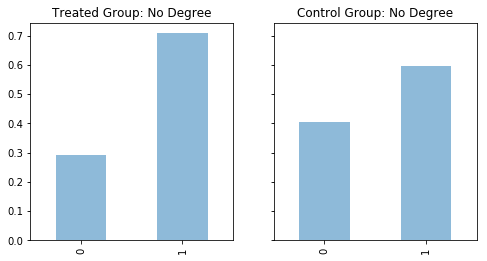

In [18]:
plot_bar(treated, control, 'nodegree','No Degree')

We verify that the number of people with no degrees is simillar in both cases.

**But how high were the `real earnings` before the treatment? And how do they compare to the ones from 1978?** 

In [19]:
print('Average treated group real earnings in: \n1974: {}\n1975: {}'.format(treated.re74.mean(), treated.re75.mean()))
print('\nAverage control group real earnings in: \n1974: {}\n1975: {}'.format(control.re74.mean(), control.re75.mean()))

Average treated group real earnings in: 
1974: 2095.573688648649
1975: 1532.055313783784

Average control group real earnings in: 
1974: 5619.236506386947
1975: 2466.4844431235447


We see that the data is biased since the control group already had higher earnings before the beginning of the treatment! A more interest comparison would be to compare the difference between the earnings before and after the treatment. 

Keeping this in mind we create the following features:
- `re_PreTreament`: average of the earnings of 1974 and 1975:
- `improvement`: difference between the earnings in 1978 and the average of the earnings of 1974 and 1975

In [20]:
#define re_PreTreatment
treated['re_PreTreatment']=(treated['re75']+treated['re74'])/2
control['re_PreTreatment']=(control['re75']+control['re74'])/2

#define improvement
treated['improvement']=treated['re78']-treated['re_PreTreatment']
control['improvement']=control['re78']-control['re_PreTreatment']

Which group has a higher `improvement`:

In [21]:
print('Average improvement in the TREATED group: ', treated.improvement.mean())
print('Average improvement in the CONTROL group: ', control.improvement.mean())

Average improvement in the TREATED group:  4535.329029054054
Average improvement in the CONTROL group:  2941.3092675524467


From the values above the conclusion we take is completely different!

To ilustrate more intuitively, we will overlap the histogram distribution of the real earnings before and after treatment:

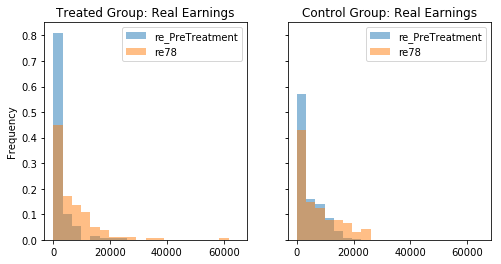

In [22]:
plot_hist(treated, control, ['re_PreTreatment', 're78'], 'Real Earnings', (0,65000))

**Conclusion**

If at some point, naively, we thought that the program was not effective, these values show the oposite!

By the observation of the histogram above, it's noticeable that the difference between the real earnings before and after treatment in the Treated Group is more striking then in the Control Group.

This leads us to conclude that the programe is in fact effective.

### 1.3. A propensity score model<a class="anchor" id="13"></a>

#### Question Instructions

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Answer

**Propensity Score Matching**:
To apply the propensity score matching, we will follow the following steps:

1. Run logistic regression **Question (1.3)**

2. Check that propensity score is balanced across treatment and comparison groups, and check that covariates are balanced across treatment and comparison groups within strata of the propensity score. **Question (1.3)**

3. Match each participant to one or more nonparticipants on propensity score **Question (1.4)**

4. Verify that covariates are balanced across treatment and comparison groups in the matched or weighted sample **Question (1.5)**

5. Multivariate analysis based on new sample **Question (1.6)**

**Run Logistic Regression**

In [23]:
features = df[["age","educ","black","hispan","married","nodegree","re74","re75","re78"]]
labels = df["treat"]

logistic = LogisticRegression()
logistic.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**Check that propensity score is balanced across treatment and comparison groups**

We create a new column in the dataframe,`probability_treat`, which represents the probability of receiving the treatment:

In [24]:
df['probability_treat'] = logistic.predict_proba(features) [:,1]
df = df.reset_index()

#add feature to sub dfs:
treated = treated.reset_index()
treated = pd.merge(treated, df[['id','probability_treat']], how='inner',left_on='id', right_on = 'id')
control = control.reset_index()
control = pd.merge(control, df[['id','probability_treat']], how='inner',left_on='id', right_on = 'id')

Let's observe if `probability_treat` is balanced across treatment and comparison groups, plotting an histogram:

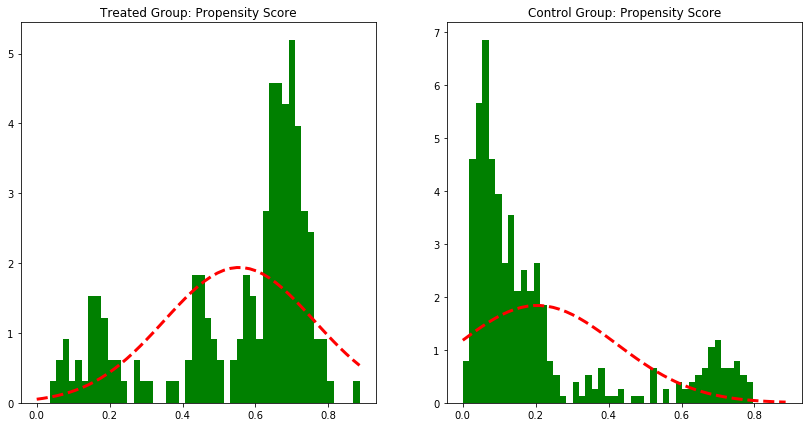

In [25]:
plot_distribution(df[(df.treat == 1)], df[(df.treat == 0)], 'probability_treat', 'Propensity Score')

In [26]:
print('treated group mean:', df[(df.treat ==1)].probability_treat.mean())
print('control group mean:', df[(df.treat ==0)].probability_treat.mean())

treated group mean: 0.5554526099228634
control group mean: 0.20415456067918075


As one would expect, we see that the propensity score is not balanced across the two groups, which introduce some bias on the results we've seen so far. To compensate such difference, we apply a **propensity score match**.

### 1.4. Balancing the dataset via matching <a class="anchor" id="14"></a>

#### Question Instructions

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Answer

In this section we follow on with the referred methods refered above to apply the propensity score matching.

**Match each participant to one or more nonparticipants on propensity score**

In [27]:
import networkx as nx
from networkx.algorithms import bipartite

def create_graph(df):
    """
    Creates graph where each id identify a node.
    :param df: DataFrame
    :return: Graph
    """
    graph = nx.Graph()
    for i in range(2):
        graph.add_nodes_from(df[df['treat'] == i].id, bipartite = i)
    return graph

def match_nodes(treated_df, control_df, graph):
    """
    We follow on with the creation of edges where each weight corresponds to the diference of propensity score.
    To find the "cheapest" matches we use the function "nx.max_weight_matching"
    Note however, that we have to insert a '-' signal, to transform a minimization problem into a maximization.
    :param treated_df: DataFrame
    :param control_df: DataFrame
    :param graph: Graph
    :return: matches by weight between control and treated groups
    """
    for row_treat in treated_df.iterrows():
        for row_control in control_df.iterrows():
            graph.add_edge(row_treat[1]['id'], row_control[1]['id'], 
                           weight = (-np.abs(row_treat[1]['probability_treat'] - row_control[1]['probability_treat'])))
    
    matches = nx.max_weight_matching(graph, maxcardinality=True)
    unidirectional_matches = dict((key, value) for (key, value) in matches.items() if key in list(treated_df.id))
    return unidirectional_matches

In [28]:
# initialize graph
graph = create_graph(df)

# create edges and find minimal weight solution
matches_dict = match_nodes(df[df.treat == 1], df[df.treat == 0], graph)

So far, we already have a dictionary with the matches with minimised cost, this is, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects.

Now we create a new `DataFrame` for the control group with the matched values, and analyse how the features are distributed after having applied the match:

In [29]:
matched_control = df[df['id'].isin(matches_dict.values())]

We check we made two equally sized groups:

In [30]:
len(matched_control) == len(treated)

True

**Feature Distribution**

We start by comparing `re78`:

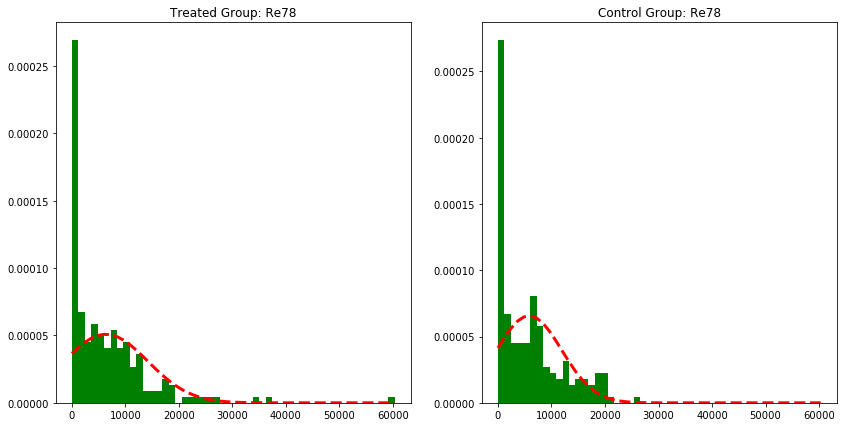

In [31]:
plot_distribution(treated, matched_control, 're78', 'Re78')

Then the remaining features:

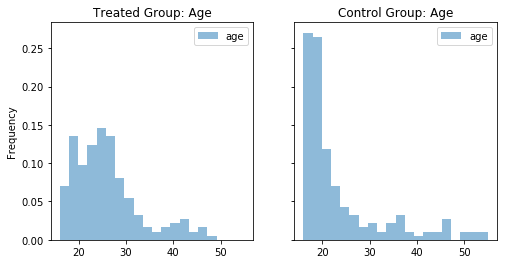

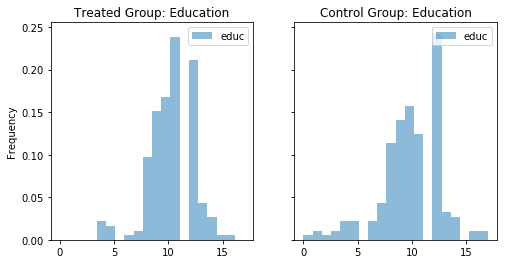

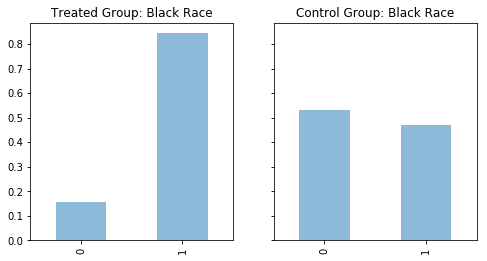

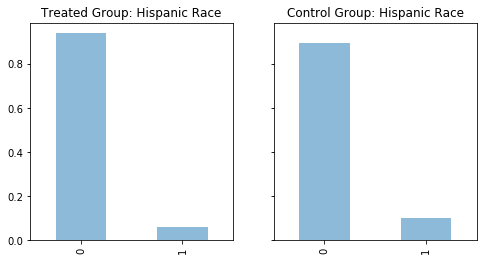

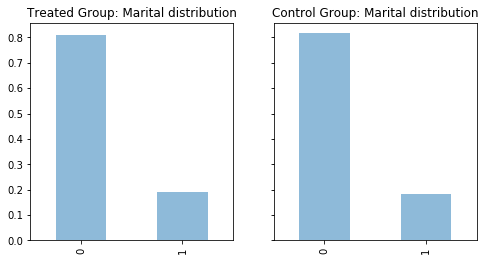

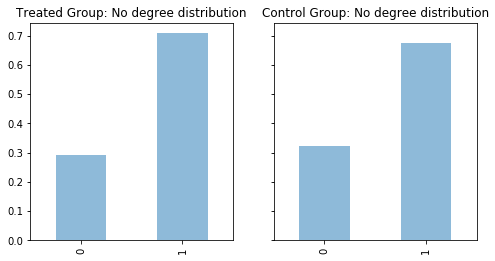

In [32]:
# age
age_range = (min(matched_control['age'].min(),treated['age'].min()),
             max(matched_control['age'].max(), treated['age'].max()))
plot_hist(treated, matched_control, ['age'], 'Age', age_range)

# years of education
educ_range = (min(matched_control['educ'].min(),treated['educ'].min()),
              max(matched_control['educ'].max(), treated['educ'].max()))
plot_hist(treated, matched_control, ['educ'], 'Education', educ_range)

# Black Race
plot_bar(treated, matched_control, 'black', 'Black Race')

# Hispanic Race
plot_bar(treated, matched_control, 'hispan', 'Hispanic Race')

# married status
plot_bar(treated, matched_control, 'married','Marital distribution')

# no degree
plot_bar(treated, matched_control, 'nodegree','No degree distribution')

**Conclusion**

We conclude that having matched the two groups using propensity score matching actually allowed to balance the distribution for all the features (including the married, which is now similar) except from the `black` (which has been balanced compared to the non-matched control group) and `age` features. We deal with this issue by trying to reinforce balancing in the next subsection.

### 1.5. Balancing the groups further <a class="anchor" id="15"></a>

Before balancing further the two groups, we want to analyse the disparity in each match. For this reson we ceate the following df:

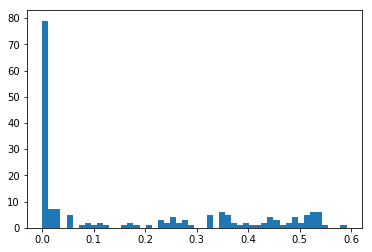

In [33]:
# include probabilitytreat in matched df
treated = df[(df.treat ==1)]

# concatenate df's
treated['control_match'] = treated['id'].map(matches_dict)
subjects = pd.merge(treated, matched_control, how='inner',
                    left_on='control_match', right_on = 'id', suffixes=('_tr', '_ctrl'))

# calculate matching error
subjects['match_error'] = np.abs(subjects['probability_treat_tr'] - subjects['probability_treat_ctrl'])
plt.hist(subjects['match_error'], bins=50);

We can verify the error is little for the majority of matches, but there are still some outliers. Part of these outliers will be removed with this following approximation. 

Note that we want to balance the black category. To do so, there are two possible approaches:

- Balance the already matched sample, removing strategicly some subjects
- Create new graph when we penalize by a factor `lambda ` matching black with non-black people

The last option seems the more meaningful one. However, since we don't have enough black people in the control group, with would be impossible to get the same percentage of black people, in the meatched control set, as we can see:

In [34]:
control_black = df[(df['black']==1)&(df['treat']==0)]
print('On maximum, we could acheve: ', round(len(control_black)/len(matched_control)*100,2), 
      '% of black people for the control group')

On maximum, we could acheve:  47.03 % of black people for the control group


Consequently, we follow on with the second approach. To guarantee the same percentage for both groups, we must have 87 black people in the treated group. Therefore, we must remove 69 black people from this group.

**How to do this efficiently?** We sort our matched dataset by propensity score, and delete the black people with the worst score:

In [35]:
#add score column
treated['score'] = 1 - subjects['match_error']

#subselect black people to filer
black_treated = treated[(treated.black == 1)]
black_treated = black_treated.sort_values(['score'], ascending = False).head(87)

#update treated df
treated = pd.concat([black_treated, treated[(treated.black == 0)]],
                    ignore_index=True).sort_values(['score'], ascending = False)

Redo Matching:

In [36]:
#initialize graph
graph_balanced = create_graph(df)

#creat edges and find minimal weight solution
matches_dict_balanced = match_nodes(treated, control, graph_balanced)

#create df for the matched control group
matched_control_balanced = df[df['id'].isin(matches_dict_balanced.values())]

**Check problematic distribution:**

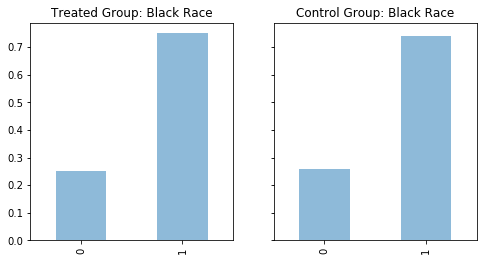

In [37]:
#Black Race
plot_bar(treated, matched_control_balanced, 'black', 'Black Race')

We verify that the problematic feature has now a similar distribution in both cases. Furthermore, removing the elements with the worst score guarantees that the remaining features balance is not affected. 

### 1.6. A less naive analysis <a class="anchor" id="16"></a>

#### Question Instructions

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Answer

Let's plot again the distribution for the `re78`:

Treated Group: Real Earnings Descripion: 
count      116.000000
mean      6761.911523
std       8757.815957
min          0.000000
25%        582.947150
50%       4402.275000
75%       9383.629500
max      60307.930000
Name: re78, dtype: float64

Control Group: Real Earnings Descripion: 
count      116.000000
mean      5677.183429
std       6566.697609
min          0.000000
25%          0.000000
50%       2939.198000
75%       9072.502000
max      25564.670000
Name: re78, dtype: float64



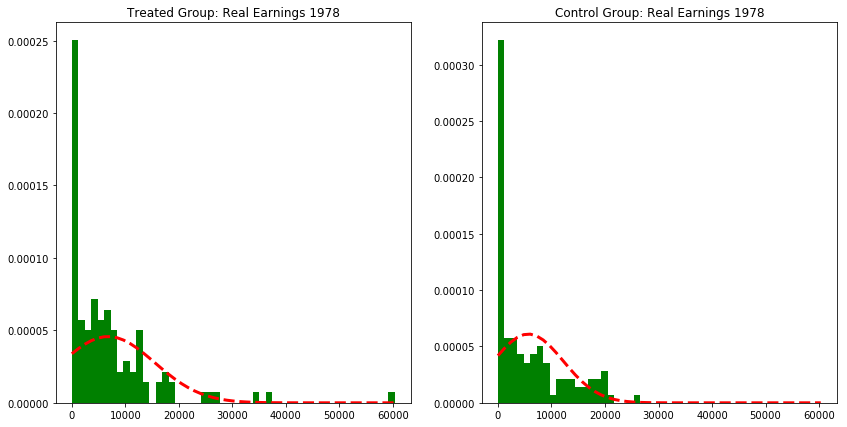

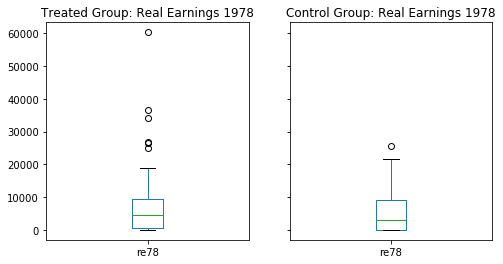

In [38]:
#plots
plot_distribution(treated, matched_control_balanced, 're78', 'Real Earnings 1978')
plot_box(treated, matched_control_balanced, 're78', 'Real Earnings 1978')

#values
print('Treated Group: Real Earnings Descripion: \n{}\n'.format(treated.re78.describe()))
print('Control Group: Real Earnings Descripion: \n{}\n'.format(matched_control_balanced.re78.describe()))

**Conclusion:**
This task represented a good example of the danger of taking wrong conclusions, due to misinterpretions of the data. In fact, is also a good example of how easily one can be manipulted if we don't look carefully to the data.

We started by observing that the treatment propgram was not effective at all since the real earnings were in average higher in the control group.

Next, we interpreted things a bit differently, and we checked not just for unbalanced features, but also for more meaningful feature combinations (e.g `improvements`).

In the last section, we managed to balance the distributions, even the ones who were harder to balance at first, and we end-up concluding the opposite of the naively analysis. It turns out that for a similar group of people, under similar conditions, the program is actually effective, as we can see in the statistics above. Not just the mean, but every quartile has a higher value in the treated group. 

## Task 2. Applied ML <a class="anchor" id="2"></a>

### Assignment Instructions

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

### 2.1. Load data <a class="anchor" id="21"></a>

#### Question Instructions

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

#### Answer

We load the whole dataset.

In [41]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all')
len(newsgroups.data)

18846

We compute TF-IDF vectors.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape

(18846, 173451)

Then we split the data into train, test and validation sets.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, newsgroups.target, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

### 2.2. Train data with random forest <a class="anchor" id="22"></a>

#### Question Instructions

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

#### Answer

We train a random forest using grid search and get the best classifier.

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Parameters
N_EST = 'n_estimators'
MAX_D = 'max_depth'
SCORE = 'score'

# Initialising variables for DataFrame
score_data = dict()
score_data[N_EST] = []
score_data[MAX_D] = []
score_data[SCORE] = []

# Initialising variables for DataFrame
best_score = 0
best_n_estimators = None
best_max_depth = None
best_classifier = None

for n_estimators in [10,50,100,200,500,1000]:
    for max_depth in [50,100,200,500,1000,2000]:
        print('Testing classifier with n_estimators = {} and max_depth = {}  '.format(n_estimators, max_depth), 
              end='\r', flush=True)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        clf.fit(X_train, y_train)
        validation_score = clf.score(X_val, y_val)
        if best_score < validation_score:
            best_score = validation_score
            best_n_estimators = n_estimators
            best_max_depth = max_depth
            best_classifier = clf
        score_data[N_EST].append(n_estimators)
        score_data[MAX_D].append(max_depth)
        score_data[SCORE].append(validation_score)

print('The classifier with the best validation score = {}, has parameters n_estimators = {} and max_depth = {}'.format(
    best_score, best_n_estimators, best_max_depth))

pd.DataFrame(score_data).pivot(index=N_EST, columns=MAX_D, values=SCORE)

The classifier with the best validation score = 0.8795755968169762, has parameters n_estimators = 1000 and max_depth = 200


max_depth,50,100,200,500,1000,2000
n_estimators,,,,,,
10,0.669496,0.739523,0.763926,0.753846,0.753846,0.753846
50,0.822812,0.846154,0.851989,0.847745,0.847745,0.847745
100,0.845093,0.865252,0.868966,0.867374,0.866313,0.866313
200,0.850398,0.863130,0.875862,0.875332,0.876393,0.876393
500,0.852520,0.868966,0.877454,0.871088,0.870557,0.870557
1000,0.854111,0.867905,0.879576,0.876923,0.878515,0.878515


The best classifier has the following parameters:

In [45]:
best_max_depth

200

In [46]:
best_n_estimators

1000

The best classifier gets the following score on the test set:

In [47]:
best_classifier.score(X_test, y_test)

0.88116710875331561

The following is the Confusion Matrix:

Confusion matrix, without normalization


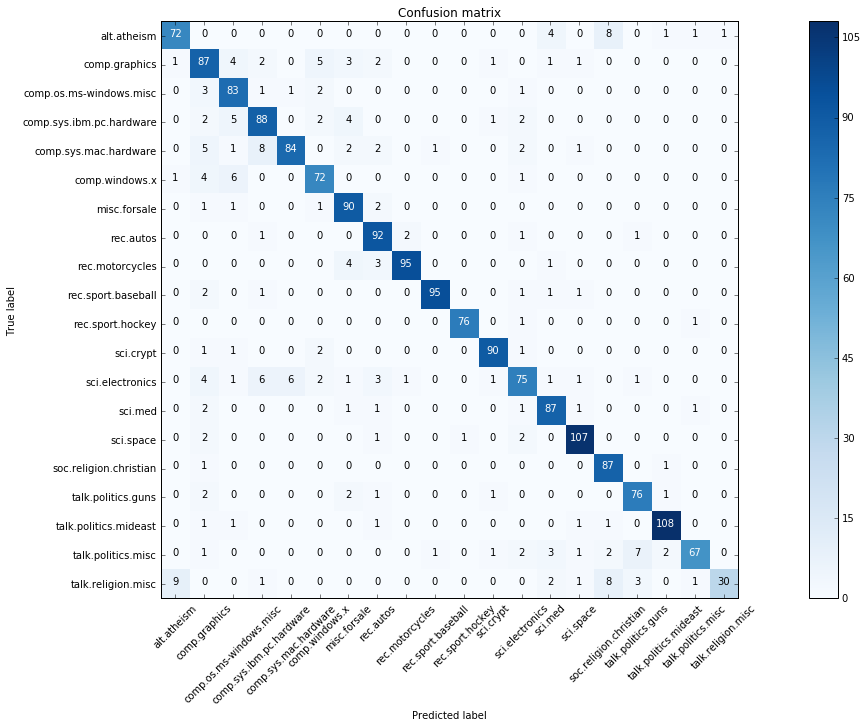

In [48]:
from sklearn.metrics import confusion_matrix
import itertools
labels = newsgroups.target_names
cm = confusion_matrix(y_test, best_classifier.predict(X_test), np.unique(y_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cm, labels)

We see that overall the classifier is performing very well and that there is no error above 10 articles.

There is a large number of words with no influence on the results. The following is the percentage of words with no importance out of the entire vocabulary:

In [49]:
len(best_classifier.feature_importances_[
    best_classifier.feature_importances_ == 0])/len(best_classifier.feature_importances_)

0.41735129806112387

The following words have the largest influence on the results, by increasing order of influence:

In [50]:
for x in np.argsort(clf.feature_importances_)[-20:]:
    print(vectorizer.get_feature_names()[x])

israel
subject
lines
edu
organization
cars
writes
encryption
graphics
baseball
god
mac
hockey
space
clipper
bike
car
dod
windows
sale


Having excluded the stop words, the most influential words are specific ones, such as hockey, graphics or Israel. That means that the classifier's performance can be explained by its meaningful choice of features.